# Image Classification with CNN

In [1]:
# for automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import Libraries

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Dataset

Download the dataset from http://files.fast.ai/data/dogscats.zip and extract it in the subdirectory of this notebook, named `data`.  
Your directory structure should be something like this.

    data/
        dogscats/
            models/
            sample/
                train/
                    cats/
                        cat.394.jpg
                        .....
                    dogs/
                        dog.1402.jpg
                        ....
                valid/
                    cats/
                        cat.394.jpg
                        .....
                    dogs/
                        dog.1402.jpg
                        ....
            test1/
                1.jpg
                2.jpg
                ...
                ...
                12500.jpg
            train/
                cats/
                    cat.394.jpg
                    .....
                dogs/
                    dog.1402.jpg
                    ....
            valid/
                cats/
                    cat.394.jpg
                    .....
                dogs/
                    dog.1402.jpg
                    ....
    Lesson 1.ipynb

In [6]:
# path to the dataset
PATH = "data/dogscats/"

In [7]:
!ls {PATH}

models	sample	test1  train  valid


In [9]:
!ls {PATH}valid

cats  dogs


In [13]:
files = !ls {PATH}valid/dogs | head
files

['dog.10001.jpg',
 'dog.10005.jpg',
 'dog.1001.jpg',
 'dog.10010.jpg',
 'dog.10018.jpg',
 'dog.10033.jpg',
 'dog.10038.jpg',
 'dog.10051.jpg',
 'dog.10063.jpg',
 'dog.1008.jpg']

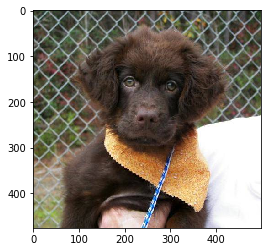

In [26]:
img = plt.imread(f'{PATH}valid/dogs/{files[6]}')
plt.imshow(img);

In [27]:
img.shape

(476, 499, 3)

In [28]:
img[:4,:4]

array([[[71, 73, 60],
        [70, 72, 59],
        [67, 67, 59],
        [63, 63, 55]],

       [[71, 73, 60],
        [70, 72, 59],
        [67, 69, 58],
        [65, 65, 57]],

       [[65, 69, 54],
        [64, 68, 53],
        [61, 65, 50],
        [61, 63, 50]],

       [[60, 68, 47],
        [59, 67, 46],
        [61, 65, 48],
        [61, 65, 50]]], dtype=uint8)